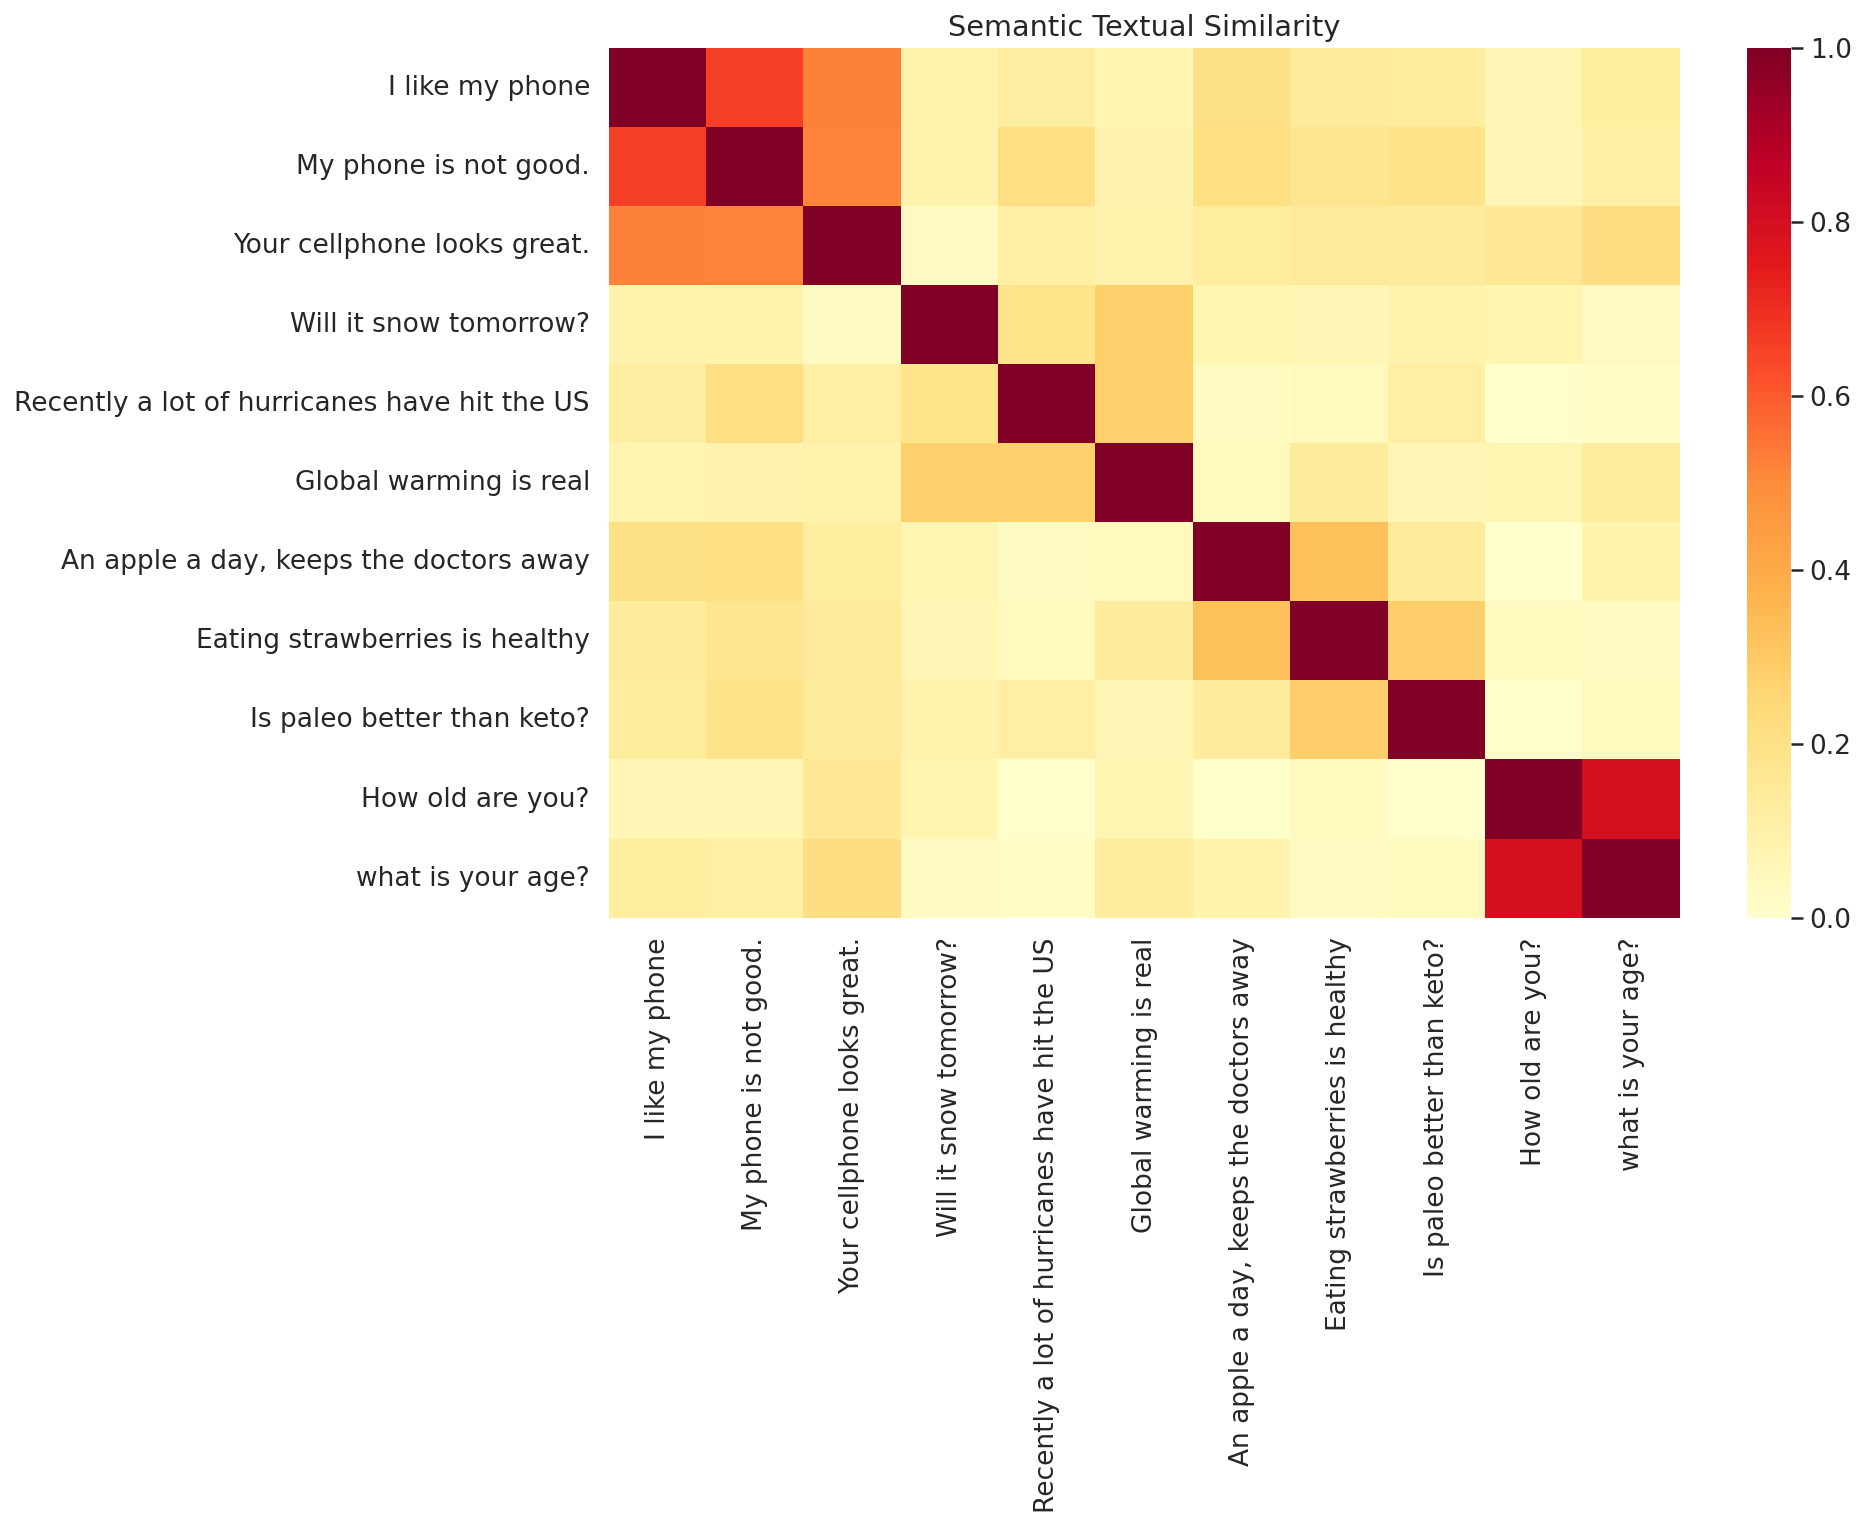

In [ ]:
import seaborn as sns
import tensorflow_hub as hub
import numpy as np


model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
def embed(input):
  return model(input)
def plot_similarity(labels, features, rotation):
  corr = np.inner(features, features)
  sns.set(font_scale=1.2)
  g = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
  g.set_xticklabels(labels, rotation=rotation)
  g.set_title("Semantic Textual Similarity")

def run_and_plot(messages_):
  message_embeddings_ = embed(messages_)
  plot_similarity(messages_, message_embeddings_, 90)


messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

run_and_plot(messages)

In [ ]:
!nvidia-smi

Sun Dec 19 17:10:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P0    60W / 149W |   2258MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install gdown
!pip install tensorflow_text

In [ ]:
!pip install wordcloud

In [ ]:
!pip install tensorflow-gpu

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow_text
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [ ]:
tf.test.is_gpu_available()

True

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/data sets/training.1600000.processed.noemoticon.csv', encoding=('ISO-8859-1'))
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [ ]:
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "Text"]
df.columns = DATASET_COLUMNS
df.head()
print(df.shape)

(1599999, 6)


In [ ]:
df.drop(['ids','date','flag','user'],axis = 1,inplace = True)
df.head()

,target,Text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [ ]:
df['target'] = df['target'].replace(4, 1)

In [ ]:
df.target.value_counts()

1    800000
0    799999
Name: target, dtype: int64

**Data Cleaning**

In [ ]:
import re
import nltk
from nltk.stem import *

# Remove pattern function
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)
  return input_txt

# Remove Twitter Handles
df['Clean_Text'] = np.vectorize(remove_pattern)(df['Text'], "@[\w]*")
df.head()

#remove links
df['Clean_Text'] = df['Clean_Text'].str.replace(r"http\S+", "")

#remove punctuation marks, numbers and special characters
df['Clean_Text'] = df['Clean_Text'].str.replace("[^a-zA-Z]", " ")

#remove stop words
nltk.download('stopwords')
stopwords=nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    clean_text=' '.join([word for word in text.split() if word not in stopwords])
    return clean_text

df['Clean_Text'] = df['Clean_Text'].apply(lambda text : remove_stopwords(text.lower()))

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,target,Text,Clean_Text
0,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
2,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,0,@Kwesidei not the whole crew,whole crew


In [ ]:
#text tokenization & normalization
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: x.split())
df.head()

,target,Text,Clean_Text
0,0,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,..."
1,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, times, ball, managed, save, rest..."
2,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]"
3,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]"
4,0,@Kwesidei not the whole crew,"[whole, crew]"


In [ ]:
#lemmatization
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])
df.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,target,Text,Clean_Text
0,0,is upset that he can't update his Facebook by ...,"[upset, update, facebook, texting, might, cry,..."
1,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, rest,..."
2,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]"
3,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, see]"
4,0,@Kwesidei not the whole crew,"[whole, crew]"


In [ ]:
#stitch tokens back together
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: ' '.join([w for w in x]))
df.head()

,target,Text,Clean_Text
0,0,is upset that he can't update his Facebook by ...,upset update facebook texting might cry result...
1,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",behaving mad see
4,0,@Kwesidei not the whole crew,whole crew


In [ ]:
#remove small words
df['Clean_Text'] = df['Clean_Text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))
df.head()

,target,Text,Clean_Text
0,0,is upset that he can't update his Facebook by ...,upset update facebook texting might result sch...
1,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest bound
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
3,0,"@nationwideclass no, it's not behaving at all....",behaving
4,0,@Kwesidei not the whole crew,whole crew


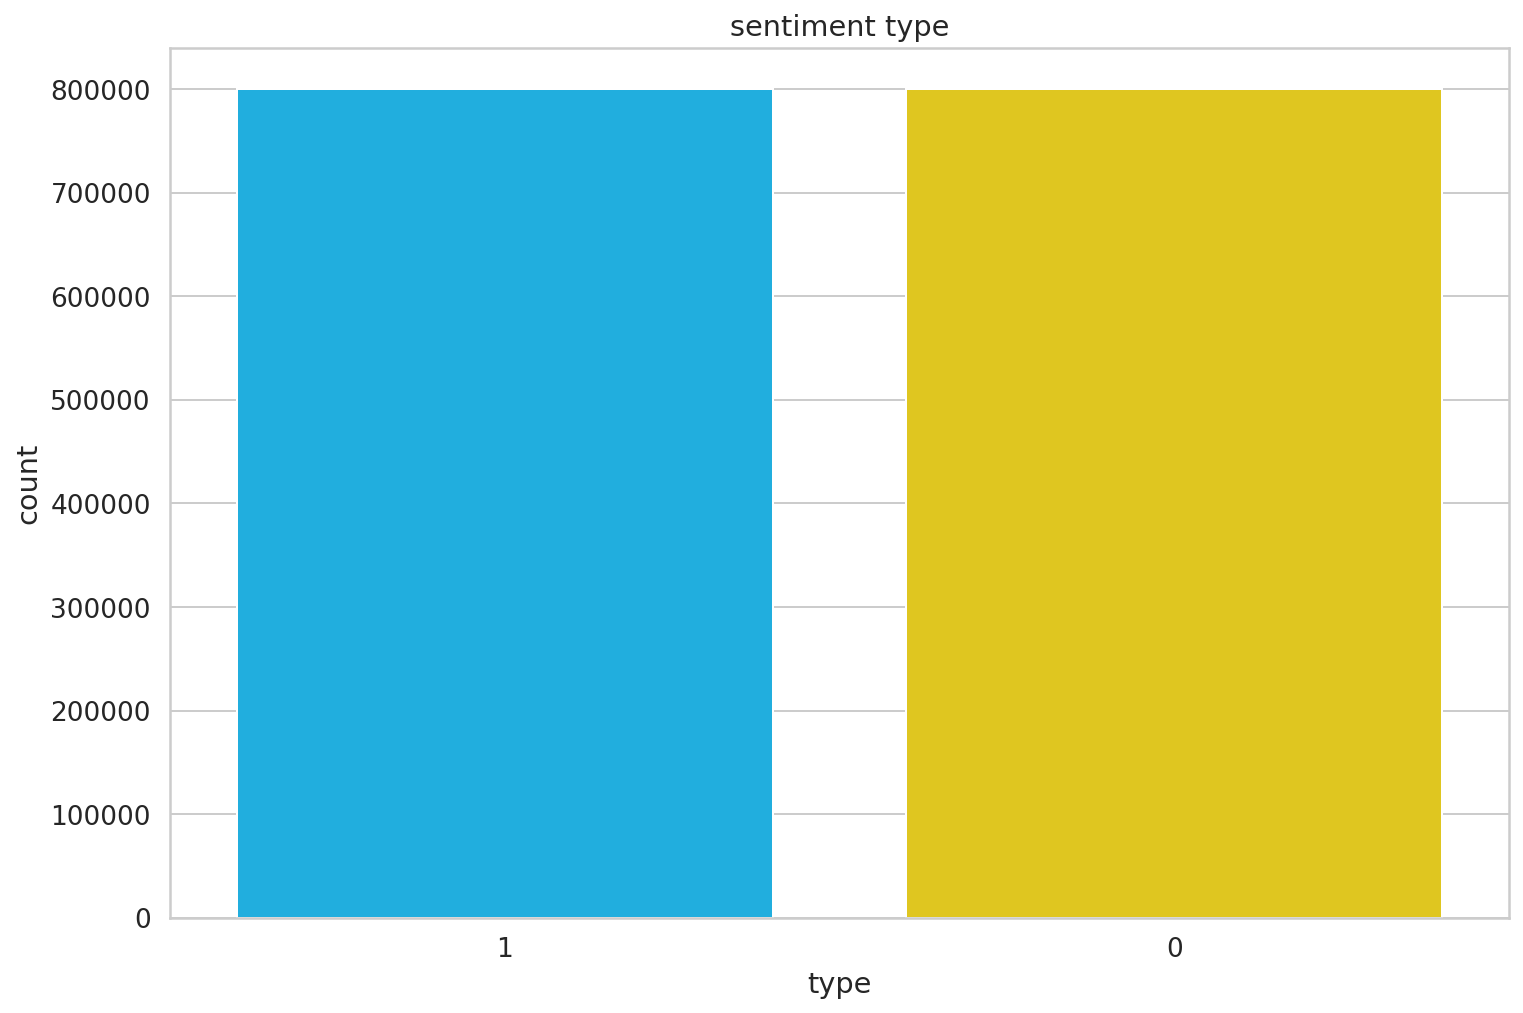

In [ ]:
sns.countplot(
  x='target',
  data=df,
  order=df.target.value_counts().index
)

plt.xlabel("type")
plt.title("sentiment type");

In [ ]:
df["sentiment_type"] = df["target"].apply(lambda x: "negative" if x == 0 else "positive")

In [ ]:
df.sentiment_type.value_counts()

positive    800000
negative    799999
Name: sentiment_type, dtype: int64

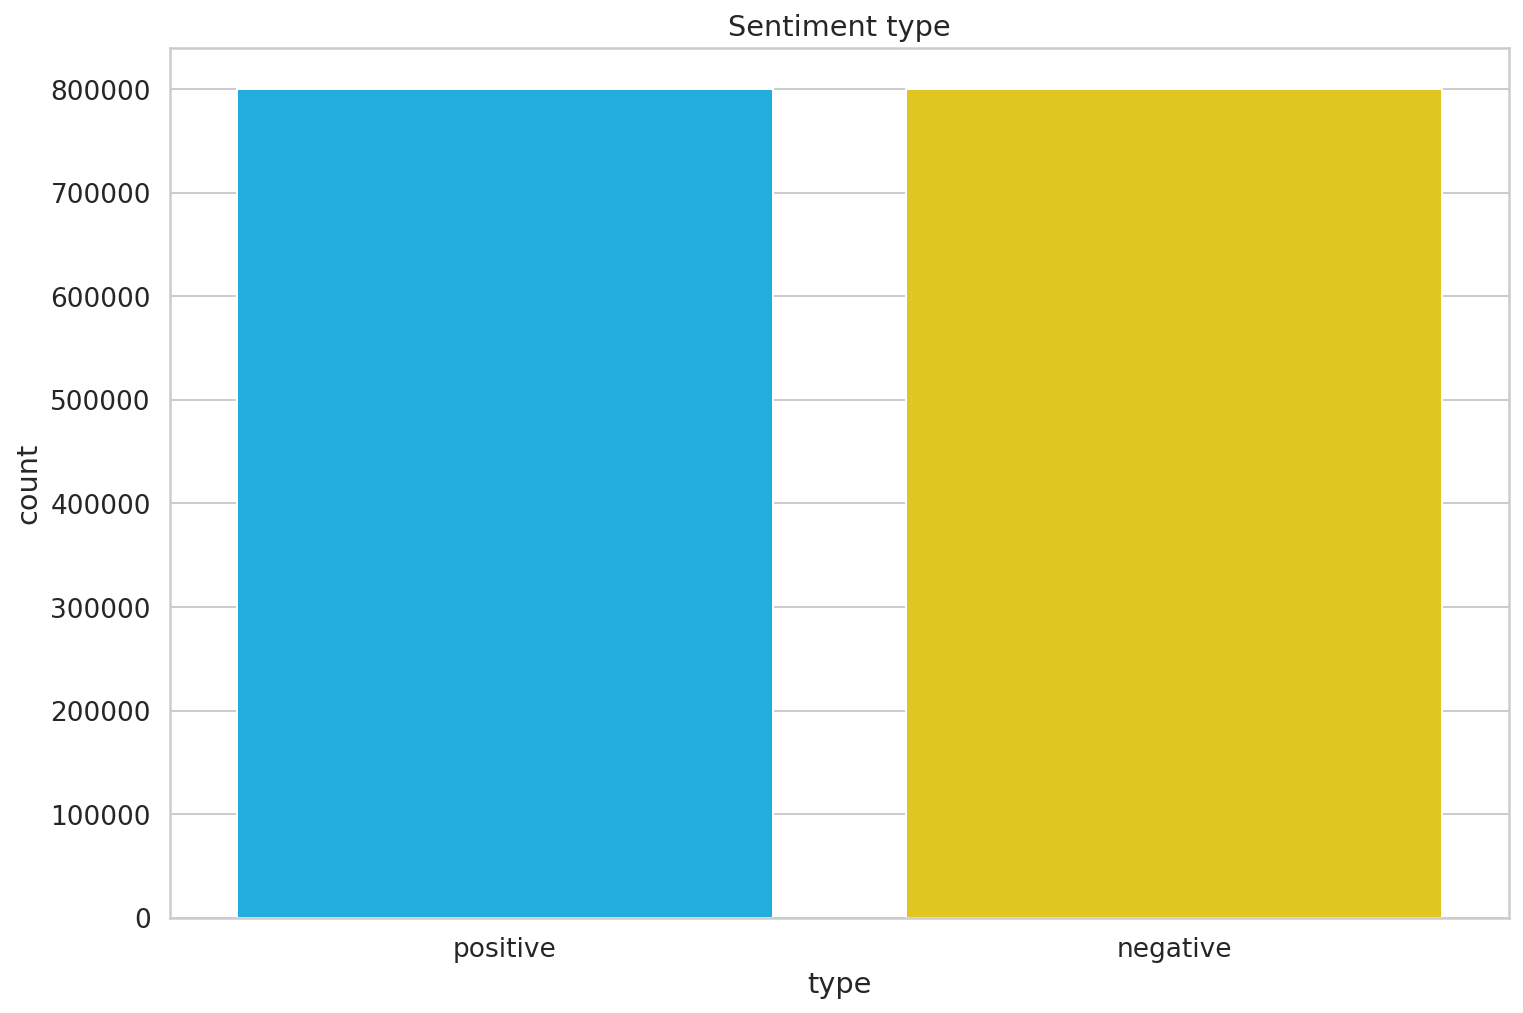

In [ ]:
sns.countplot(
  x='sentiment_type',
  data=df,
  order=df.sentiment_type.value_counts().index
)

plt.xlabel("type")
plt.title("Sentiment type");

In [ ]:
positive_sentiment = df[df.sentiment_type == "positive"]
negative_sentiment = df[df.sentiment_type == "negative"]

In [ ]:
print(positive_sentiment.shape, negative_sentiment.shape)

(800000, 4) (799999, 4)


In [ ]:
positive_sentiment_text = " ".join(positive_sentiment.Clean_Text.to_numpy().tolist())
negative_sentiment_text = " ".join(negative_sentiment.Clean_Text.to_numpy().tolist())

positive_sentiment_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(positive_sentiment_text)
negative_sentiment_cloud = WordCloud(stopwords=STOPWORDS, background_color="black").generate(negative_sentiment_text)

In [ ]:
def show_word_cloud(cloud, title):
  plt.figure(figsize = (20, 20))
  plt.imshow(cloud, interpolation='bilinear')
  plt.title(title)
  plt.axis("off")
  plt.show();

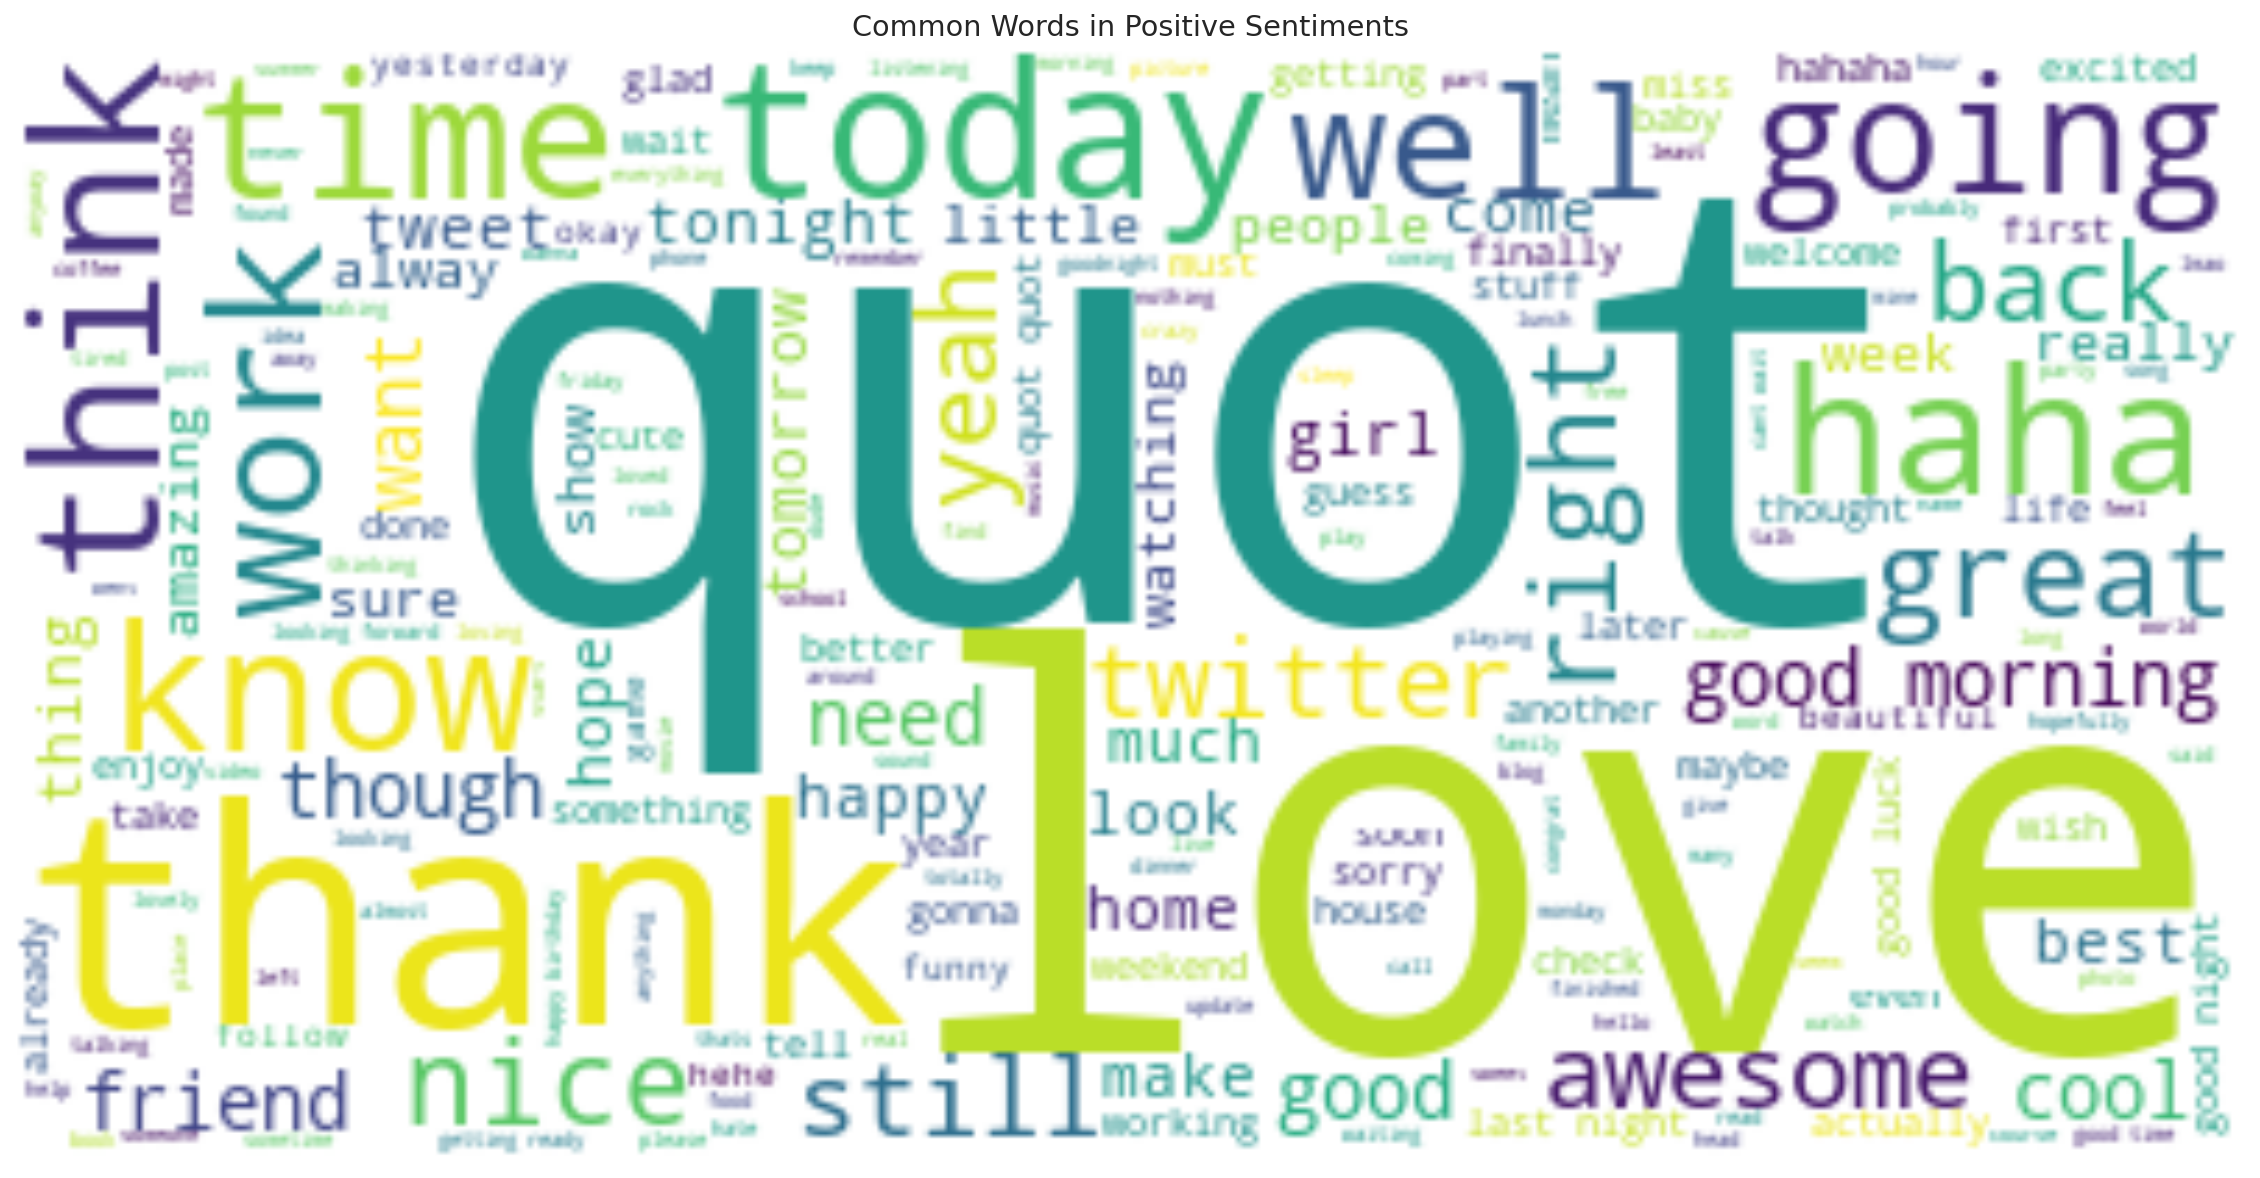

In [ ]:
show_word_cloud(positive_sentiment_cloud, "Common Words in Positive Sentiments")

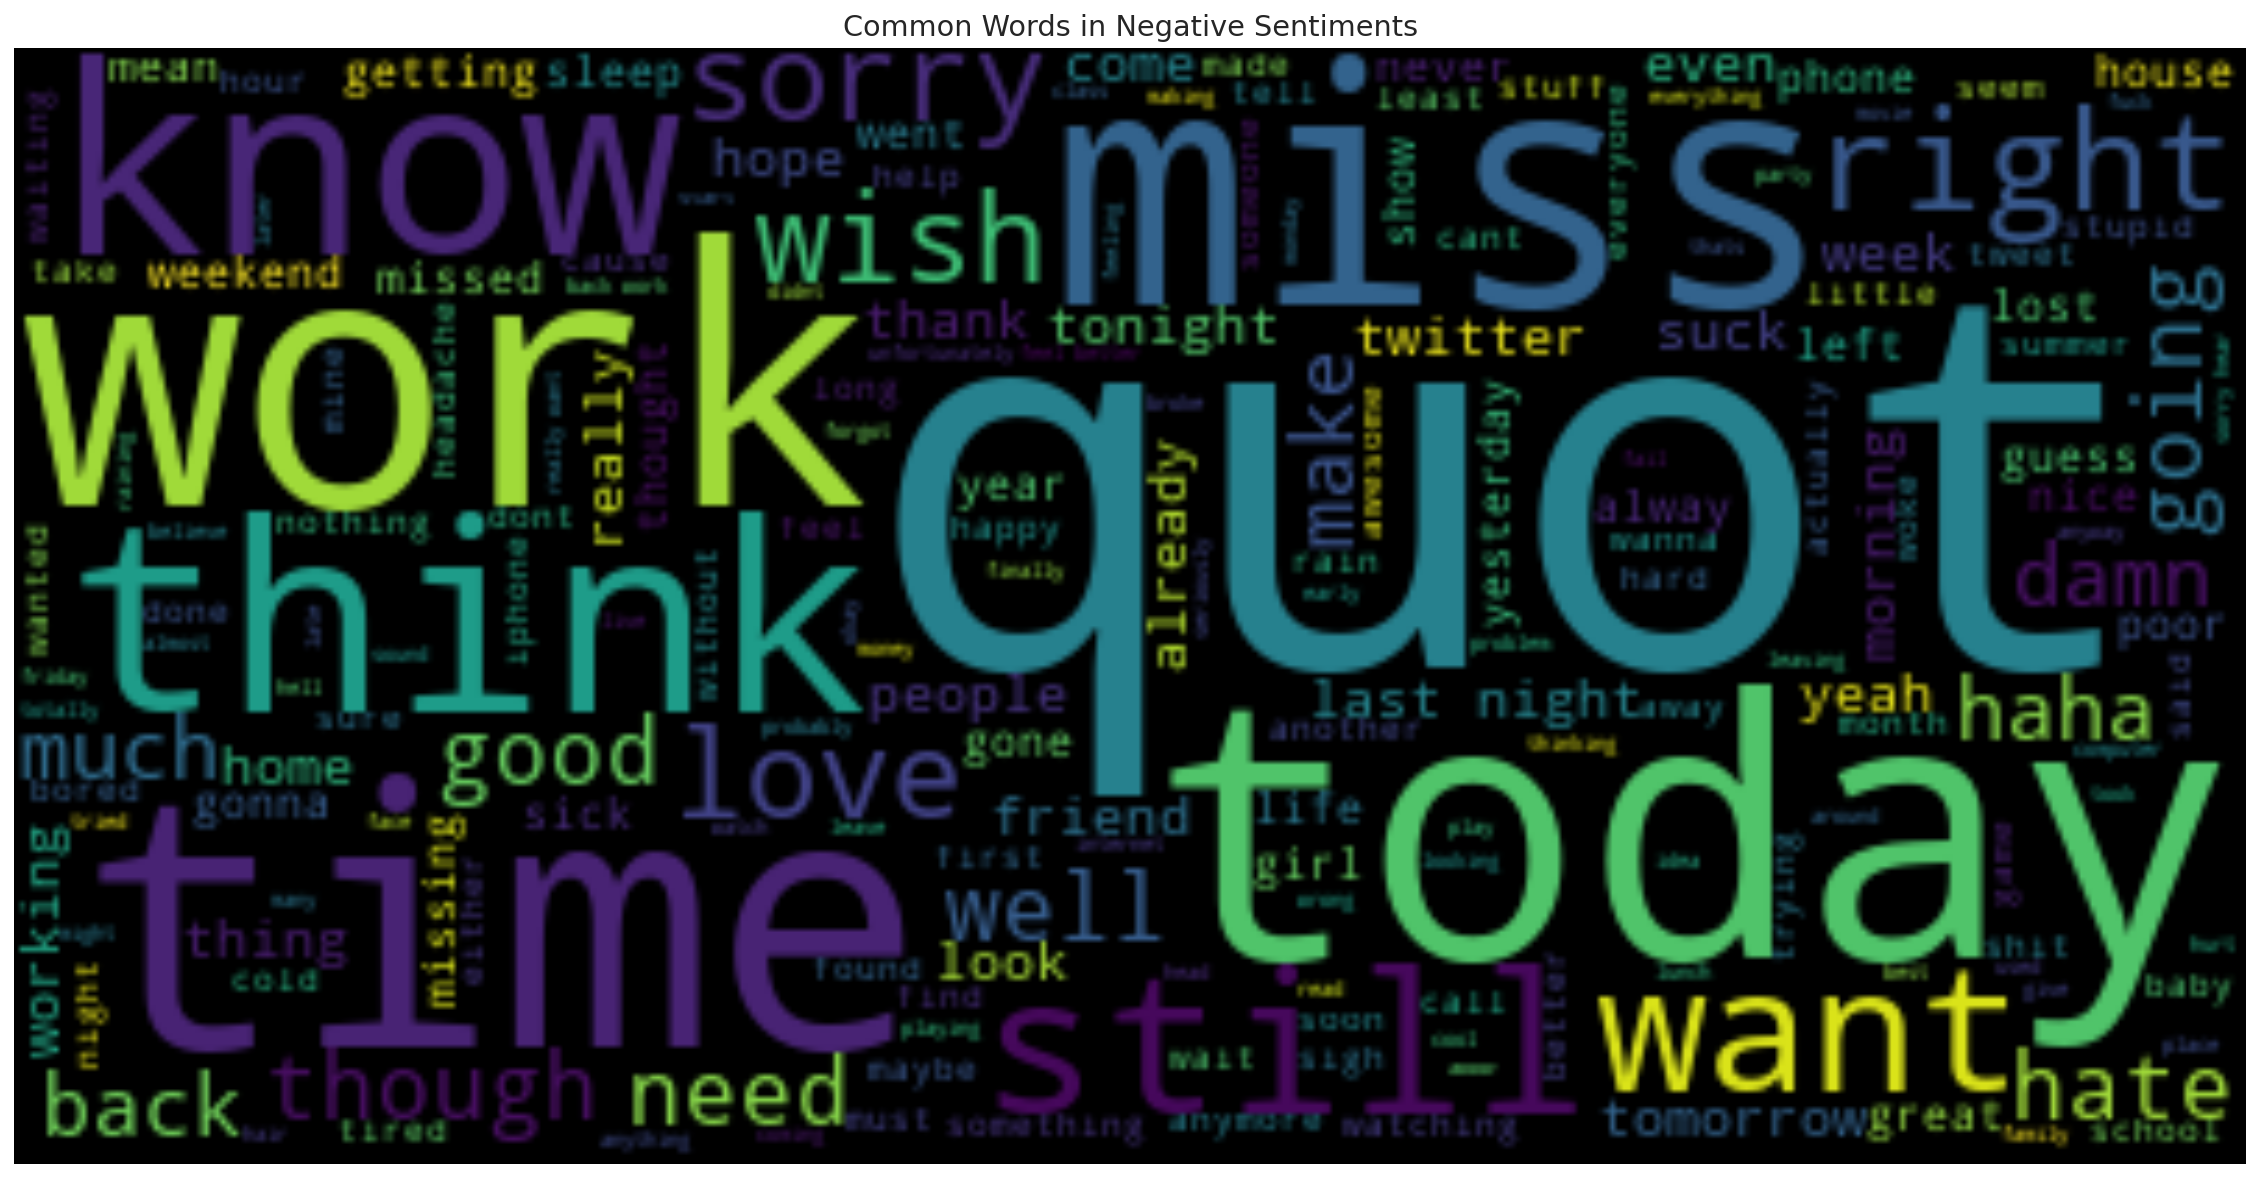

In [ ]:
show_word_cloud(negative_sentiment_cloud, "Common Words in Negative Sentiments")

In [ ]:
df.head()

,target,Text,Clean_Text,sentiment_type
0,0,is upset that he can't update his Facebook by ...,upset update facebook texting might result sch...,negative
1,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest bound,negative
2,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire,negative
3,0,"@nationwideclass no, it's not behaving at all....",behaving,negative
4,0,@Kwesidei not the whole crew,whole crew,negative
